In [181]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import networkx as nx

from collections import Counter


In [182]:
def parser(path):
    with open(path) as file:
        data = json.load(file)

    df = pd.json_normalize(data, record_path=['data'])
    return data, df

In [183]:
path = 'problems_2023_01_30/problems MoonBoard 2016 .json'

In [184]:
data, df = parser(path)

In [185]:
df.moves[0]

[{'problemId': 19215, 'description': 'E6', 'isStart': True, 'isEnd': False},
 {'problemId': 19215, 'description': 'C5', 'isStart': True, 'isEnd': False},
 {'problemId': 19215, 'description': 'E8', 'isStart': False, 'isEnd': False},
 {'problemId': 19215, 'description': 'F11', 'isStart': False, 'isEnd': False},
 {'problemId': 19215, 'description': 'C13', 'isStart': False, 'isEnd': False},
 {'problemId': 19215, 'description': 'D15', 'isStart': False, 'isEnd': False},
 {'problemId': 19215, 'description': 'D18', 'isStart': False, 'isEnd': True}]

In [186]:
df.shape

(59506, 23)

In [187]:
df.iloc[:5, :15]

,name,grade,userGrade,setbyId,setby,method,userRating,repeats,isBenchmark,isMaster,upgraded,downgraded,moves,holdsets,hasBetaVideo
0,Far from the Madding Crowd,6B+,6B+,5FC09F63-05F3-4DAE-A1A5-3AC22C37139A,Ben Moon,Feet follow hands,4,24993,True,False,False,False,"[{'problemId': 19215, 'description': 'E6', 'is...","[{'description': 'Hold Set B', 'locations': No...",True
1,Wuthering Heights,6B+,6B+,5FC09F63-05F3-4DAE-A1A5-3AC22C37139A,Ben Moon,Feet follow hands,4,35673,True,False,False,False,"[{'problemId': 19216, 'description': 'F5', 'is...","[{'description': 'Hold Set A', 'locations': No...",True
2,Problem 3,6B+,6B+,CC7D7BD1-67CD-4027-A537-22E7855C18B7,Ally Patrick,Feet follow hands,4,757,False,False,False,False,"[{'problemId': 19217, 'description': 'F5', 'is...","[{'description': 'Original School Holds', 'loc...",False
3,HARD TIMES,7A,7A,5FC09F63-05F3-4DAE-A1A5-3AC22C37139A,Ben Moon,Feet follow hands,5,8670,True,False,False,False,"[{'problemId': 19218, 'description': 'B10', 'i...","[{'description': 'Hold Set B', 'locations': No...",True
4,Problem 5,7A,7A,CC7D7BD1-67CD-4027-A537-22E7855C18B7,Ally Patrick,Feet follow hands,4,255,False,False,False,False,"[{'problemId': 19219, 'description': 'C5', 'is...","[{'description': 'Hold Set B', 'locations': No...",False


In [188]:
df.isna().sum()

name                            0
grade                           0
userGrade                   28079
setbyId                         0
setby                           0
method                          0
userRating                      0
repeats                         0
isBenchmark                     0
isMaster                        0
upgraded                        0
downgraded                      0
moves                           0
holdsets                        0
hasBetaVideo                    0
moonBoardConfigurationId        0
apiId                           0
dateInserted                    0
dateUpdated                  7203
dateDeleted                 59019
holdsetup.description           0
holdsetup.holdsets          59506
holdsetup.apiId                 0
dtype: int64

# Cleaning

In [189]:
for idx, route in enumerate(df['moves']):
    for move in route:
        if move['description'] == 'j5':
            df['moves'][idx][route.index(move)]['description'] = 'J5'

In [190]:
# sort all moves from bottom to top, left to right
def sort_moves(moves):
    return sorted(moves, key=lambda x: (int(x['description'][1:]), x['description'][0]))

df['moves'] = df['moves'].apply(sort_moves)

In [191]:
# remove duplicate moves
def remove_duplicate_dicts(lst):
    seen = set()
    new_lst = []
    for d in lst:
        # Convert dictionary to a tuple of items and check if it's already seen
        t = tuple(sorted(d.items()))
        if t not in seen:
            seen.add(t)
            new_lst.append(d)
    return new_lst

# Apply the function to the moves column
df['moves'] = df['moves'].apply(remove_duplicate_dicts)

In [192]:
df = df[df.grade != '6B']

# Filtering Criteria

In [193]:
# Length filter
df = df[(df['moves'].apply(len) > 3) & (df['moves'].apply(len) < 16)]

In [194]:
# N starting holds filter
df = df[df['moves'].apply(lambda moves: sum(1 for move in moves if move['isStart']) <= 2)]

In [195]:
# Euclid filter

In [196]:
# Get rid of climbs with 'A6' and change 'j6' to positive
df[df['moves'].apply(lambda moves: any(move['description'] == 'A6' for move in moves))]


,name,grade,userGrade,setbyId,setby,method,userRating,repeats,isBenchmark,isMaster,...,holdsets,hasBetaVideo,moonBoardConfigurationId,apiId,dateInserted,dateUpdated,dateDeleted,holdsetup.description,holdsetup.holdsets,holdsetup.apiId


# Creating Board

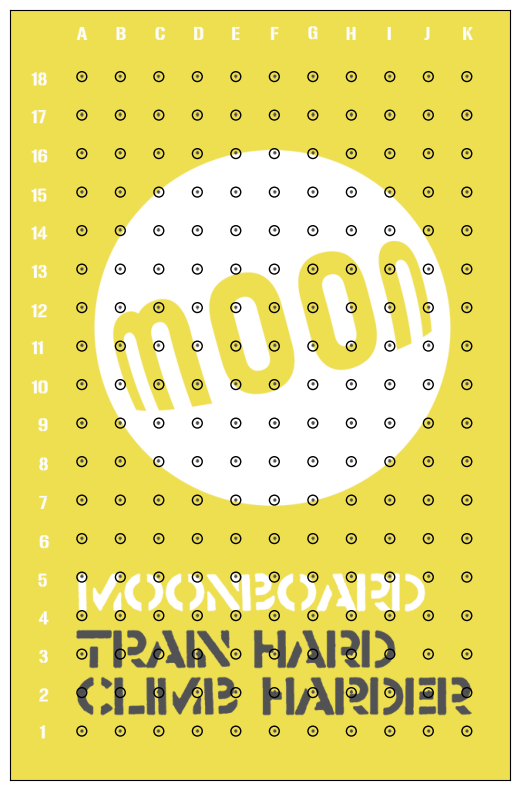

In [132]:
h_incpt = 93.3
h_scalar = 50
v_incpt = 63.5
v_scalar = 50

holds = []

for row in range(18):
    for col in range(11):
        hold_id = f"{chr(65 + col)}{row + 1}"
        x = h_incpt + h_scalar * col
        y = v_incpt + v_scalar * row
        holds.append({"id": hold_id, "x": x, "y": y})

def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

G = nx.Graph()
for hold in holds:
    G.add_node(hold['id'], pos=(hold['x'], hold['y']))

for i, hold1 in enumerate(holds):
    for hold2 in holds[i+1:]:
        if euclidean_distance(hold1['x'], hold1['y'], hold2['x'], hold2['y']) <= 2 * h_scalar:  # Assuming h_scalar = v_scalar for simplicity
            G.add_edge(hold1['id'], hold2['id'])

wall_img = mpimg.imread('moonboard-background.png') 
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(wall_img, extent=[0, wall_img.shape[1], 0, wall_img.shape[0]])

pos = {hold['id']: (hold['x'], hold['y']) for hold in holds}
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=50, node_color='none', edgecolors='black')
# nx.draw_networkx_edges(G, pos, ax=ax, edge_color='black')

plt.show()

In [133]:
example_moves = [
    {"problemId": 19215, "description": "E6", "isStart": True, "isEnd": False},
    {"problemId": 19215, "description": "C5", "isStart": True, "isEnd": False},
    {"problemId": 19215, "description": "E8", "isStart": False, "isEnd": False},
    {"problemId": 19215, "description": "F11", "isStart": False, "isEnd": False},
    {"problemId": 19215, "description": "C13", "isStart": False, "isEnd": False},
    {"problemId": 19215, "description": "D15", "isStart": False, "isEnd": False},
    {"problemId": 19215, "description": "D18", "isStart": False, "isEnd": True},
]

def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def route_viz(moves, holds=holds):
    G = nx.Graph()
    for hold in holds:
        G.add_node(hold['id'], pos=(hold['x'], hold['y']))

    pos = {hold['id']: (hold['x'], hold['y']) for hold in holds}

    route_holds = [move['description'] for move in moves]
    start_holds = [move['description'] for move in moves if move['isStart']]
    end_holds = [move['description'] for move in moves if move['isEnd']]

    closest_edges = []
    for current_hold in route_holds:
        distances = []
        current_pos = pos[current_hold]
        for other_hold in route_holds:
            if other_hold != current_hold:
                other_pos = pos[other_hold]
                distance = euclidean_distance(current_pos[0], current_pos[1], other_pos[0], other_pos[1])
                distances.append((distance, other_hold))
        closest_holds = sorted(distances, key=lambda x: x[0])[:3]
        for _, hold_id in closest_holds:
            if (current_hold, hold_id) not in closest_edges and (hold_id, current_hold) not in closest_edges:
                closest_edges.append((current_hold, hold_id))

    wall_img_path = 'moonboard-background.png'
    wall_img = mpimg.imread(wall_img_path)

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(wall_img, extent=[0, wall_img.shape[1], 0, wall_img.shape[0]])

    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=50, node_color='none', edgecolors='grey', alpha=0.5)
    nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=route_holds, node_size=50, node_color='blue', edgecolors='black')
    nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=start_holds, node_size=50, node_color='green', edgecolors='black')
    nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=end_holds, node_size=50, node_color='red', edgecolors='black')
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=closest_edges, edge_color='black', width=2, style='dashed')

    print(closest_edges)
    plt.show()


In [134]:
# def euclidean_distance(x1, y1, x2, y2):
#     return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

# def route_viz(moves, holds=holds):
#     G = nx.Graph()
#     for hold in holds:
#         G.add_node(hold['id'], pos=(hold['x'], hold['y']))

#     pos = {hold['id']: (hold['x'], hold['y']) for hold in holds}

#     route_holds = [move['description'] for move in moves]
#     start_holds = [move['description'] for move in moves if move['isStart']]
#     end_holds = [move['description'] for move in moves if move['isEnd']]

#     route_holds.sort(key=lambda x: pos[x][1])

#     closest_edges = []
#     for i, current_hold in enumerate(route_holds):
#         current_pos = pos[current_hold]
#         closest_distance = float('inf')
#         closest_hold = None
#         for next_hold in route_holds[i + 1:]:
#             next_pos = pos[next_hold]
#             distance = euclidean_distance(current_pos[0], current_pos[1], next_pos[0], next_pos[1])
#             if distance < closest_distance:
#                 closest_distance = distance
#                 closest_hold = next_hold
#         if closest_hold:
#             closest_edges.append((current_hold, closest_hold))

#     wall_img_path = 'moonboard-background.png'
#     wall_img = mpimg.imread(wall_img_path)

#     fig, ax = plt.subplots(figsize=(15, 10))
#     ax.imshow(wall_img, extent=[0, wall_img.shape[1], 0, wall_img.shape[0]])

#     print(route_holds)
#     nx.draw_networkx_nodes(G, pos, ax=ax, node_size=50, node_color='none', edgecolors='grey', alpha=0.5)
#     nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=route_holds, node_size=50, node_color='blue', edgecolors='black')
#     nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=start_holds, node_size=50, node_color='green', edgecolors='black')
#     nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=end_holds, node_size=50, node_color='red', edgecolors='black')
#     nx.draw_networkx_edges(G, pos, ax=ax, edgelist=closest_edges, edge_color='black', width=2, style='dashed')

#     plt.show()

In [135]:
# def euclidean_distance(x1, y1, x2, y2):
#     return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

# def route_viz(moves, holds=holds):
#     G = nx.Graph()
#     for hold in holds:
#         G.add_node(hold['id'], pos=(hold['x'], hold['y']))

#     pos = {hold['id']: (hold['x'], hold['y']) for hold in holds}

#     route_holds = [move['description'] for move in moves]
#     start_holds = [move['description'] for move in moves if move['isStart']]
#     end_holds = [move['description'] for move in moves if move['isEnd']]

#     route_holds.sort(key=lambda x: pos[x][1])

#     closest_edges = []
#     for i, current_hold in enumerate(route_holds[:-1]):
#         current_pos = pos[current_hold]
#         next_hold = route_holds[i + 1]
#         next_pos = pos[next_hold]
#         # distance = euclidean_distance(current_pos[0], current_pos[1], next_pos[0], next_pos[1])
#         closest_edges.append((current_hold, next_hold))

#     wall_img_path = 'moonboard-background.png'
#     wall_img = mpimg.imread(wall_img_path)

#     fig, ax = plt.subplots(figsize=(15, 10))
#     ax.imshow(wall_img, extent=[0, wall_img.shape[1], 0, wall_img.shape[0]])

#     print(route_holds)
#     nx.draw_networkx_nodes(G, pos, ax=ax, node_size=50, node_color='none', edgecolors='grey', alpha=0.5)
#     nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=route_holds, node_size=50, node_color='blue', edgecolors='black')
#     nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=start_holds, node_size=50, node_color='green', edgecolors='black')
#     nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=end_holds, node_size=50, node_color='red', edgecolors='black')
#     nx.draw_networkx_edges(G, pos, ax=ax, edgelist=closest_edges, edge_color='black', width=2, style='dashed')

#     plt.show()


In [136]:
moves = df['moves'][66]
set(move['description'] for move in moves)

{'A18', 'B15', 'B6', 'C5', 'D15', 'E8', 'G17', 'H12', 'H16', 'I10', 'K14'}

7A
[('C5', 'B6'), ('C5', 'E8'), ('C5', 'I10'), ('B6', 'E8'), ('B6', 'I10'), ('E8', 'I10'), ('I10', 'H12'), ('I10', 'K14'), ('H12', 'K14'), ('H12', 'H16'), ('K14', 'H16'), ('B15', 'D15'), ('B15', 'A18'), ('B15', 'G17'), ('D15', 'G17'), ('D15', 'H16'), ('H16', 'G17'), ('G17', 'K14'), ('A18', 'D15'), ('A18', 'G17')]


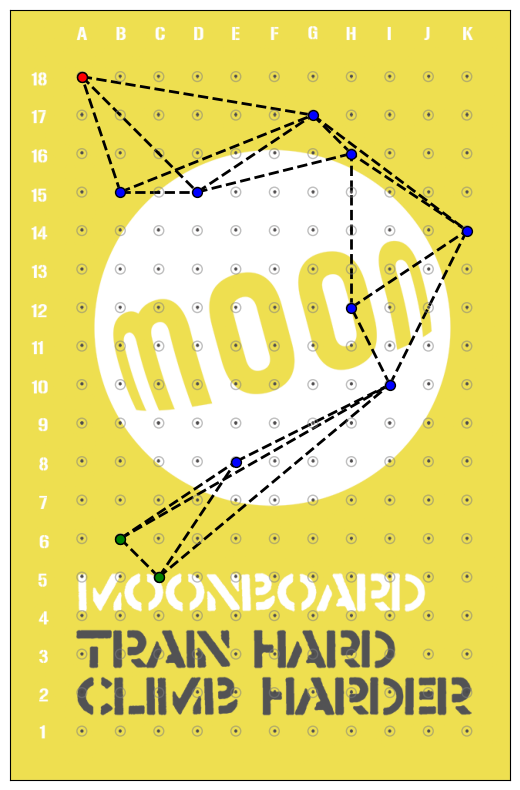

In [137]:
print(df.iloc[66]['grade'])
route_viz(df['moves'][66])

6B+
[('F5', 'B8'), ('F5', 'F10'), ('F5', 'B11'), ('B8', 'B11'), ('B8', 'F10'), ('F10', 'E13'), ('F10', 'B11'), ('B11', 'E13'), ('E13', 'E15'), ('E15', 'G18'), ('E15', 'B11'), ('G18', 'E13'), ('G18', 'F10')]


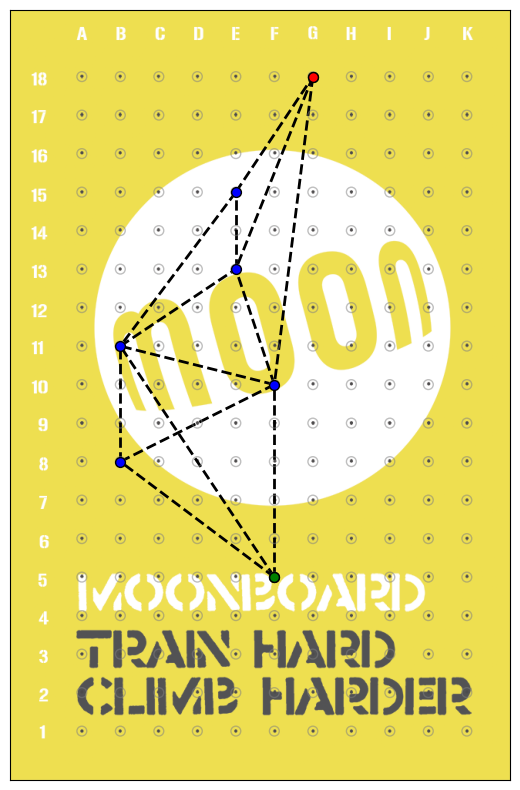

In [138]:
print(df.iloc[55]['grade'])
route_viz(df['moves'][55])

7A+
[('J2', 'H8'), ('J2', 'E6'), ('J2', 'H9'), ('E6', 'H8'), ('E6', 'H9'), ('H8', 'H9'), ('H8', 'I12'), ('H9', 'I12'), ('H9', 'K11'), ('K11', 'I12'), ('K11', 'H8'), ('K16', 'H18'), ('K16', 'I12'), ('K16', 'K11'), ('H18', 'I12'), ('H18', 'K11')]


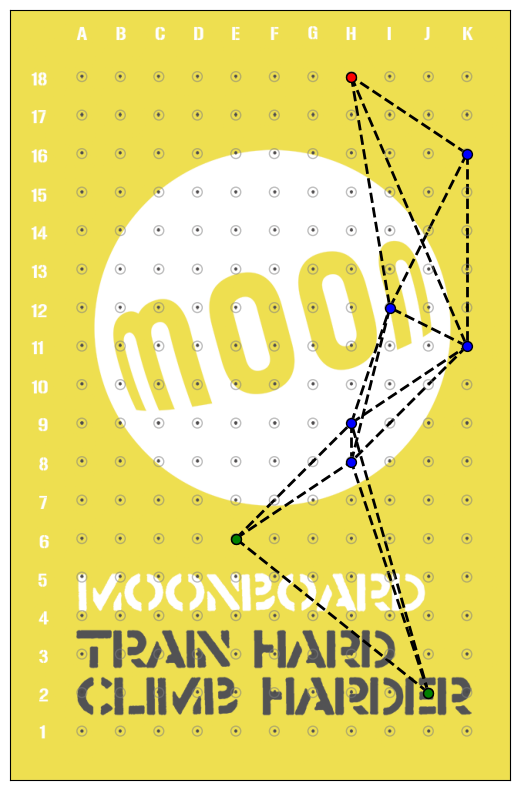

In [139]:
print(df.iloc[44528]['grade'])
route_viz(df['moves'][44528])

In [140]:
df.moves[10]

[{'problemId': 19225, 'description': 'C5', 'isStart': True, 'isEnd': False},
 {'problemId': 19225, 'description': 'B6', 'isStart': True, 'isEnd': False},
 {'problemId': 19225, 'description': 'E8', 'isStart': False, 'isEnd': False},
 {'problemId': 19225, 'description': 'B10', 'isStart': False, 'isEnd': False},
 {'problemId': 19225, 'description': 'E14', 'isStart': False, 'isEnd': False},
 {'problemId': 19225, 'description': 'E16', 'isStart': False, 'isEnd': False},
 {'problemId': 19225, 'description': 'I18', 'isStart': False, 'isEnd': True}]

In [141]:
def heatmap(df):
    hold_usage = {}
    for index, row in df.iterrows():
        moves = row['moves']
        for move in moves:
            description = move['description']
            if description in hold_usage:
                hold_usage[description] += 1
            else:
                hold_usage[description] = 1

    max_usage = max(hold_usage.values())
    min_usage = min(hold_usage.values())
    usage_normalized = {hold: (usage - min_usage) / (max_usage - min_usage) for hold, usage in hold_usage.items()}

    cmap = plt.get_cmap('coolwarm')
    node_colors = [cmap(usage_normalized.get(hold['id'], 0)) for hold in holds]

    fig, ax = plt.subplots(figsize=(10, 8))
    G = nx.Graph()
    for hold in holds:
        G.add_node(hold['id'], pos=(hold['x'], hold['y']))

    nx.draw(G, pos={hold['id']: (hold['x'], hold['y']) for hold in holds}, node_color=node_colors, with_labels=True, ax=ax)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_usage, vmax=max_usage))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label='Hold Usage Frequency')

    plt.show()


In [142]:
df['grade'].value_counts()

grade
6B+    19147
6C+     9105
7A      7968
6C      7425
7A+     6036
7B+     3280
7B      2832
7C      2063
7C+      975
8A       403
8A+      108
8B+       60
8B        59
Name: count, dtype: int64

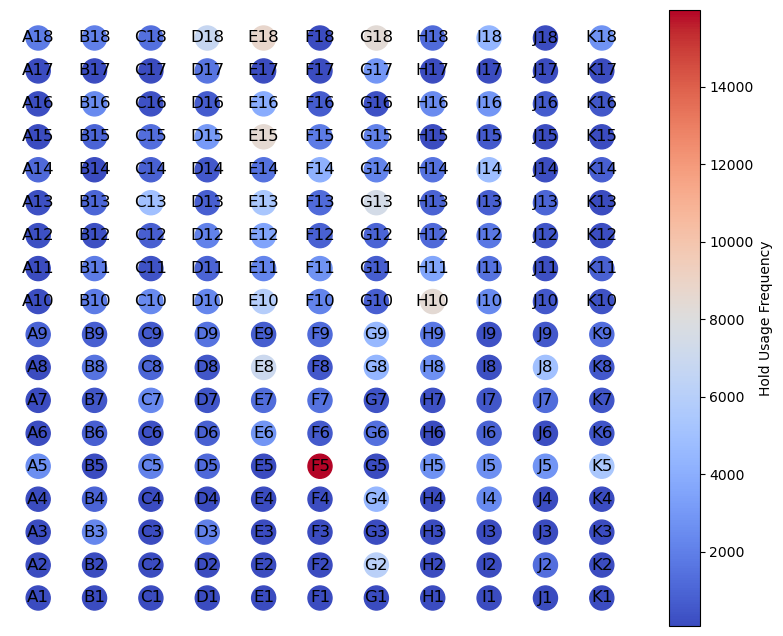

In [143]:
# Easier Grades
heatmap(df[df['grade'].isin(['6B+', '6C', '6C+'])])

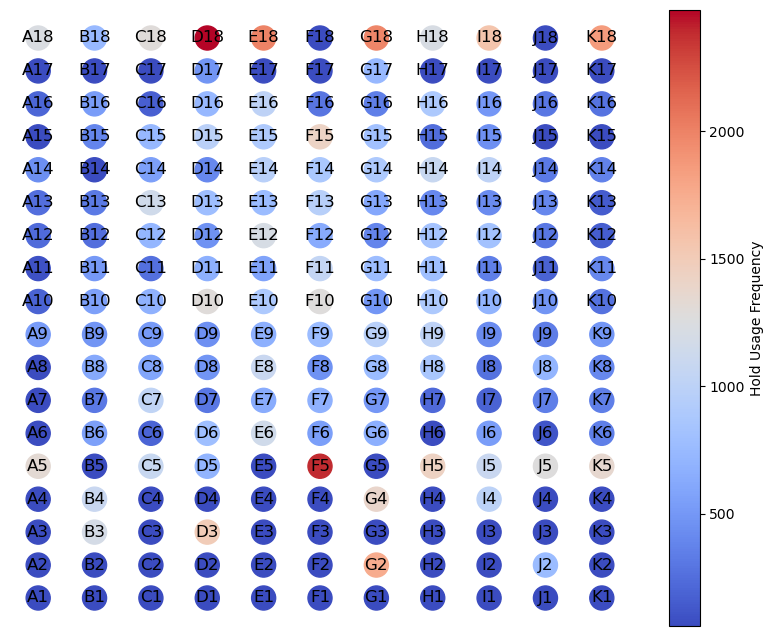

In [144]:
# Intermediates 
heatmap(df[df['grade'].isin(['7A', '7A+', '7B' '7B+'])])

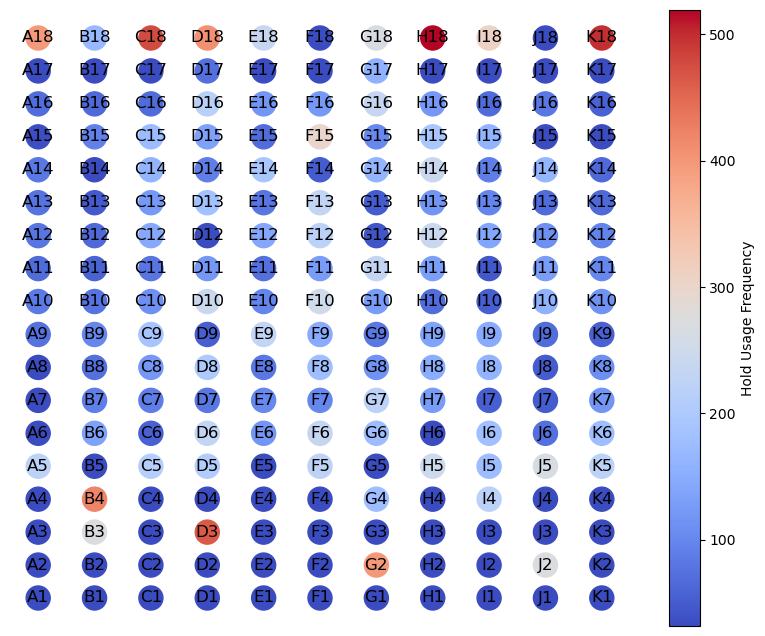

In [145]:
# hard
heatmap(df[df['grade'].isin(['7C', '7C+', '8A' '8A+', '8B', '8B+'])])

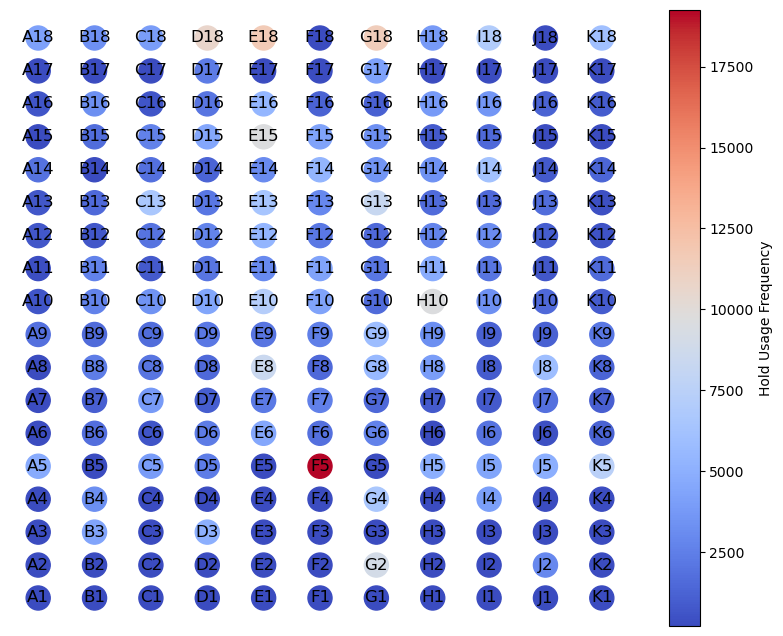

In [146]:
# all grades
heatmap(df)

In [147]:
def edge_viz(df_moves, holds=holds):
    G = nx.Graph()
    for hold in holds:
        G.add_node(hold['id'], pos=(hold['x'], hold['y']))

    pos = {hold['id']: (hold['x'], hold['y']) for hold in holds}

    edge_weights = {}
    for moves in df_moves:
        route_holds = [move['description'] for move in moves]

        closest_edges = []
        for current_hold in route_holds:
            distances = []
            current_pos = pos[current_hold]
            for other_hold in route_holds:
                if other_hold != current_hold:
                    other_pos = pos[other_hold]
                    distance = euclidean_distance(current_pos[0], current_pos[1], other_pos[0], other_pos[1])
                    distances.append((distance, other_hold))
            closest_holds = sorted(distances, key=lambda x: x[0])[:3]
            for _, hold_id in closest_holds:
                if (current_hold, hold_id) not in closest_edges and (hold_id, current_hold) not in closest_edges:
                    closest_edges.append((current_hold, hold_id))

        for edge in closest_edges:
            if edge in edge_weights:
                edge_weights[edge] += 1
            else:
                edge_weights[edge] = 1

    sorted_weights_list = sorted(edge_weights.items(), key=lambda item: item[1], reverse=True)
    # Get top n most common climbs
    top_10_pairs = sorted_weights_list[:15]
    sorted_weights_top_10 = {k: v for k, v in top_10_pairs}

    wall_img_path = 'moonboard-background.png'
    wall_img = mpimg.imread(wall_img_path)

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(wall_img, extent=[0, wall_img.shape[1], 0, wall_img.shape[0]])

    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=50, node_color='none', edgecolors='grey', alpha=0.5)
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=sorted_weights_top_10.keys(), edge_color='black', width=2, style='dashed')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=sorted_weights_top_10, ax=ax)

    plt.show()

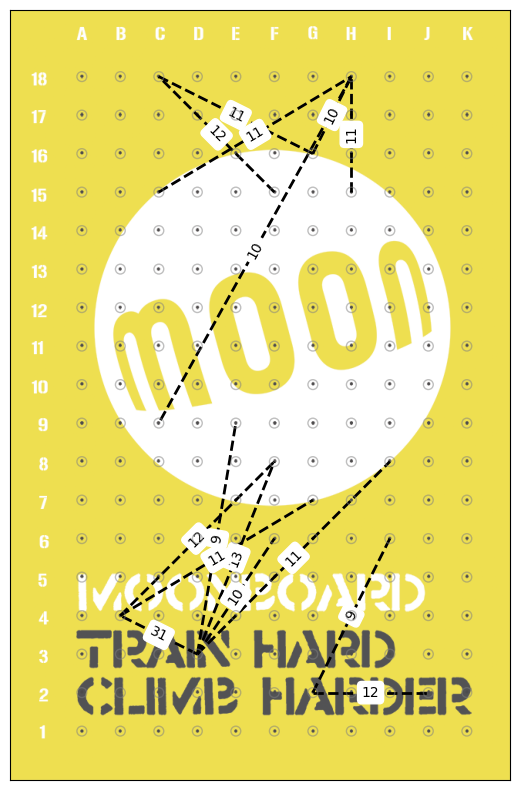

In [148]:
filtered_df = df[df.grade == '8A']
edge_viz(filtered_df['moves'])

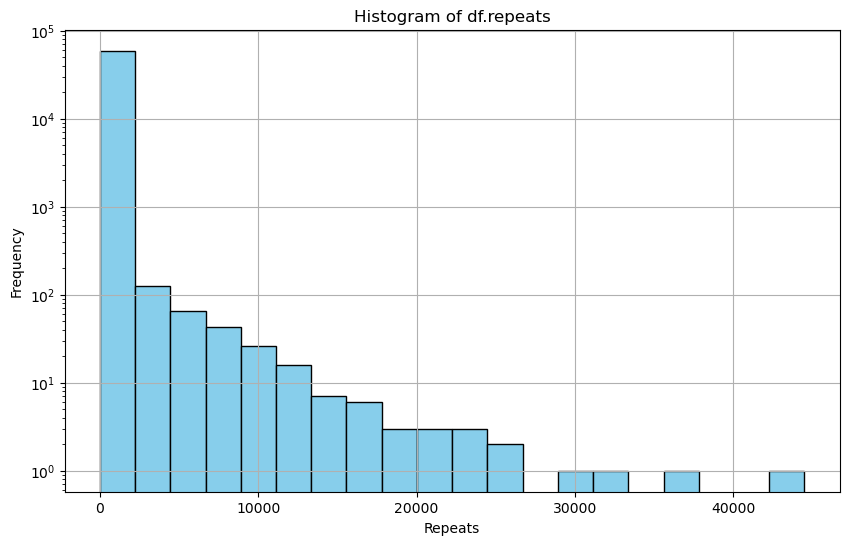

In [149]:
plt.figure(figsize=(10, 6))
plt.hist(df.repeats, bins=20, color='skyblue', edgecolor='black', log=True) 
plt.title('Histogram of df.repeats')
plt.xlabel('Repeats')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Climbs to try:
belliot bsnsob

finorza

# Modeling

In [150]:
hold_descriptions = ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1', 'K1',
                     'A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2', 'I2', 'J2', 'K2',
                     'A3', 'B3', 'C3', 'D3', 'E3', 'F3', 'G3', 'H3', 'I3', 'J3', 'K3',
                     'A4', 'B4', 'C4', 'D4', 'E4', 'F4', 'G4', 'H4', 'I4', 'J4', 'K4',
                     'A5', 'B5', 'C5', 'D5', 'E5', 'F5', 'G5', 'H5', 'I5', 'J5', 'K5',
                     'A6', 'B6', 'C6', 'D6', 'E6', 'F6', 'G6', 'H6', 'I6', 'J6', 'K6',
                     'A7', 'B7', 'C7', 'D7', 'E7', 'F7', 'G7', 'H7', 'I7', 'J7', 'K7',
                     'A8', 'B8', 'C8', 'D8', 'E8', 'F8', 'G8', 'H8', 'I8', 'J8', 'K8',
                     'A9', 'B9', 'C9', 'D9', 'E9', 'F9', 'G9', 'H9', 'I9', 'J9', 'K9',
                     'A10', 'B10', 'C10', 'D10', 'E10', 'F10', 'G10', 'H10', 'I10', 'J10', 'K10',
                     'A11', 'B11', 'C11', 'D11', 'E11', 'F11', 'G11', 'H11', 'I11', 'J11', 'K11',
                     'A12', 'B12', 'C12', 'D12', 'E12', 'F12', 'G12', 'H12', 'I12', 'J12', 'K12',
                     'A13', 'B13', 'C13', 'D13', 'E13', 'F13', 'G13', 'H13', 'I13', 'J13', 'K13',
                     'A14', 'B14', 'C14', 'D14', 'E14', 'F14', 'G14', 'H14', 'I14', 'J14', 'K14',
                     'A15', 'B15', 'C15', 'D15', 'E15', 'F15', 'G15', 'H15', 'I15', 'J15', 'K15',
                     'A16', 'B16', 'C16', 'D16', 'E16', 'F16', 'G16', 'H16', 'I16', 'J16', 'K16',
                     'A17', 'B17', 'C17', 'D17', 'E17', 'F17', 'G17', 'H17', 'I17', 'J17', 'K17',
                     'A18', 'B18', 'C18', 'D18', 'E18', 'F18', 'G18', 'H18', 'I18', 'J18', 'K18']

for col in hold_descriptions:
    df[col] = False

# Iterate over each row in the dataframe
for index, row in df.iterrows():
    # Check if each hold description exists in the moves
    for move in row['moves']:
        description = move['description']
        if description in hold_descriptions:
            df.at[index, description] = True

/var/folders/9j/yz2b3p150qs_j0s6v9cznbk80000gn/T/ipykernel_21467/4133150243.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = False
/var/folders/9j/yz2b3p150qs_j0s6v9cznbk80000gn/T/ipykernel_21467/4133150243.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = False
/var/folders/9j/yz2b3p150qs_j0s6v9cznbk80000gn/T/ipykernel_21467/4133150243.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

In [151]:
df[:5]

,name,grade,userGrade,setbyId,setby,method,userRating,repeats,isBenchmark,isMaster,...,B18,C18,D18,E18,F18,G18,H18,I18,J18,K18
0,Far from the Madding Crowd,6B+,6B+,5FC09F63-05F3-4DAE-A1A5-3AC22C37139A,Ben Moon,Feet follow hands,4,24993,True,False,...,False,False,True,False,False,False,False,False,False,False
1,Wuthering Heights,6B+,6B+,5FC09F63-05F3-4DAE-A1A5-3AC22C37139A,Ben Moon,Feet follow hands,4,35673,True,False,...,False,False,False,True,False,False,False,False,False,False
2,Problem 3,6B+,6B+,CC7D7BD1-67CD-4027-A537-22E7855C18B7,Ally Patrick,Feet follow hands,4,757,False,False,...,False,False,False,False,False,False,False,True,False,False
3,HARD TIMES,7A,7A,5FC09F63-05F3-4DAE-A1A5-3AC22C37139A,Ben Moon,Feet follow hands,5,8670,True,False,...,False,False,False,False,False,False,False,True,False,False
4,Problem 5,7A,7A,CC7D7BD1-67CD-4027-A537-22E7855C18B7,Ally Patrick,Feet follow hands,4,255,False,False,...,False,False,True,False,False,False,False,False,False,False


<function matplotlib.pyplot.show(close=None, block=None)>

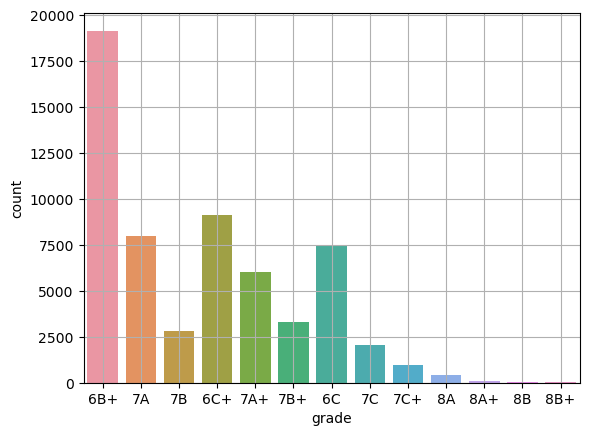

In [152]:
import seaborn as sns

sns.countplot(df, x='grade')
plt.grid('show')
plt.show

# Exploring outlier climbs

In [153]:
df.grade.value_counts()

grade
6B+    19147
6C+     9105
7A      7968
6C      7425
7A+     6036
7B+     3280
7B      2832
7C      2063
7C+      975
8A       403
8A+      108
8B+       60
8B        59
Name: count, dtype: int64

In [154]:
n_moves = [len(moves) for moves in df.moves]
move_len = np.array(n_moves)
move_len.mean(), move_len.min(), move_len.max()

(7.570104774558113, 4, 15)

In [155]:
n_moves = df['moves'].apply(len)
indexes = df[n_moves == 4].index

# Display the indexes
print(indexes)

Index([  492,   726,   905,   957,   958,  1112,  1139,  1174,  1180,  1191,
       ...
       58970, 59018, 59101, 59222, 59256, 59276, 59315, 59381, 59401, 59444],
      dtype='int64', length=738)


6C+ 0 Funky now
[('F5', 'I10'), ('F5', 'G13'), ('F5', 'E18'), ('I10', 'G13'), ('I10', 'E18'), ('G13', 'E18')]


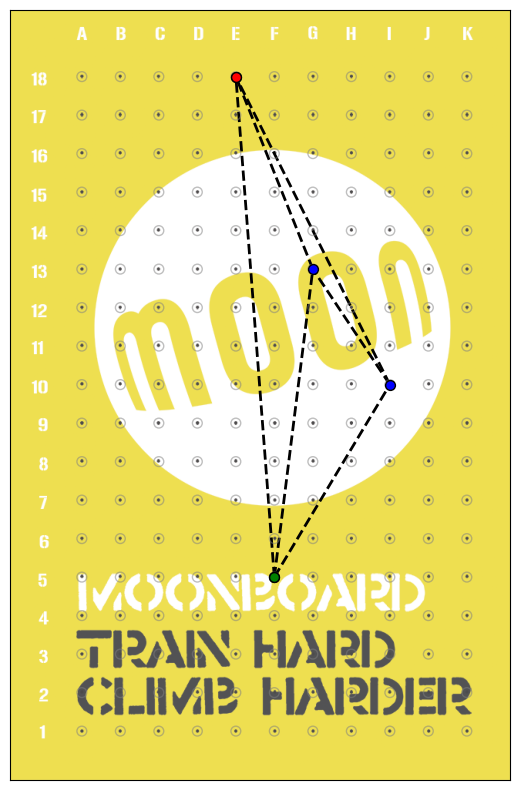

In [156]:
idx = 1112
print(df.iloc[idx]['grade'], df.iloc[idx]['repeats'], df.iloc[idx]['name'])
route_viz(df['moves'][idx])

In [157]:
df.grade.value_counts()

grade
6B+    19147
6C+     9105
7A      7968
6C      7425
7A+     6036
7B+     3280
7B      2832
7C      2063
7C+      975
8A       403
8A+      108
8B+       60
8B        59
Name: count, dtype: int64

# Probability Distributions

In [158]:
df_easy = df[df['grade'].isin(['6B', '6B+', '6C', '6C+'])].reset_index() # V4 - V5
df_medium = df[df['grade'].isin(['7A', '7A+'])].reset_index() # V6 - V7
df_hard = df[df['grade'].isin(['7B', '7B+', '7C'])].reset_index() # V8 - V9
df_vhard = df[df['grade'].isin(['7C+', '8A', '8A+', '8B', '8B+'])].reset_index() # V10 - V13

In [159]:
df_vhard.moves[300]

[{'problemId': 313687, 'description': 'B4', 'isStart': True, 'isEnd': False},
 {'problemId': 313687, 'description': 'G7', 'isStart': False, 'isEnd': False},
 {'problemId': 313687, 'description': 'I8', 'isStart': False, 'isEnd': False},
 {'problemId': 313687, 'description': 'A11', 'isStart': False, 'isEnd': False},
 {'problemId': 313687, 'description': 'J14', 'isStart': False, 'isEnd': False},
 {'problemId': 313687, 'description': 'H15', 'isStart': False, 'isEnd': False},
 {'problemId': 313687, 'description': 'C18', 'isStart': False, 'isEnd': True}]

In [160]:
from collections import defaultdict

def update_count_matrix(moves, count_matrix):
    for i in range(len(moves) - 1):
        current_move = moves[i]
        
        if current_move['isEnd']:
            continue
        
        for j in range(i + 1, len(moves)):
            next_move = moves[j]
            if not next_move['isStart']:
                count_matrix[next_move['description']][current_move['description']] += 1
                break

def generate_count_df(df):
    count_matrix = defaultdict(lambda: defaultdict(int))

    for moves in df['moves']:
        update_count_matrix(moves, count_matrix)

    count_df = pd.DataFrame(count_matrix).fillna(0).astype(int)

    # Get unique hold names from the DataFrame columns and index
    hold_names = sorted(set(count_df.index).union(count_df.columns), key=lambda x: (x[0], int(x[1:])))

    # Reindex the DataFrame to ensure it is sorted alphabetically and numerically
    count_df = count_df.reindex(index=hold_names, columns=hold_names, fill_value=0)
    
    return count_df

def generate_probability_matrix(count_df):
    probability_matrix = count_df.div(count_df.sum(axis=1), axis=0).fillna(0)
    return probability_matrix

# Generate count_df and probability_matrix for each difficulty category
count_df_easy = generate_count_df(df_easy)
probability_matrix_easy = generate_probability_matrix(count_df_easy)

count_df_medium = generate_count_df(df_medium)
probability_matrix_medium = generate_probability_matrix(count_df_medium)

count_df_hard = generate_count_df(df_hard)
probability_matrix_hard = generate_probability_matrix(count_df_hard)

count_df_vhard = generate_count_df(df_vhard)
probability_matrix_vhard = generate_probability_matrix(count_df_vhard)


In [161]:
def calculate_starting_hold_probabilities(df):
    starting_holds = set()

    # Collect all unique starting holds
    for moves in df['moves']:
        for move in moves:
            if move['isStart']:
                starting_holds.add(move['description'])

    # Calculate probability of being a starting hold
    total_routes = len(df)
    prob_starting_hold = {}

    for hold in starting_holds:
        count_start = sum(1 for moves in df['moves'] if any(move['description'] == hold for move in moves if move['isStart']))
        prob_starting_hold[hold] = count_start / total_routes

    # Normalize probabilities so that they sum to one
    total_prob = sum(prob_starting_hold.values())
    for hold in prob_starting_hold:
        prob_starting_hold[hold] /= total_prob

    return starting_holds, prob_starting_hold

# Calculate starting hold probabilities for each difficulty category
starting_holds_easy, prob_starting_hold_easy = calculate_starting_hold_probabilities(df_easy)
starting_holds_medium, prob_starting_hold_medium = calculate_starting_hold_probabilities(df_medium)
starting_holds_hard, prob_starting_hold_hard = calculate_starting_hold_probabilities(df_hard)
starting_holds_vhard, prob_starting_hold_vhard = calculate_starting_hold_probabilities(df_vhard)

prob_starting_hold_easy

{'J6': 0.001494433236195173,
 'C5': 0.0355114697750878,
 'J2': 0.019932003287753124,
 'F5': 0.2862960472240903,
 'C6': 0.0034185160277964586,
 'D6': 0.010815960546962565,
 'I6': 0.01391690951206755,
 'F6': 0.006201897930209969,
 'G6': 0.017111260554434734,
 'D3': 0.02208025106478368,
 'E6': 0.0415826047971307,
 'B4': 0.015915713965478594,
 'B3': 0.04057386236269895,
 'K5': 0.08975939624897258,
 'H5': 0.04580437868938206,
 'I5': 0.04658895613838452,
 'G4': 0.07550623925876113,
 'J5': 0.044403347530449076,
 'G2': 0.0658858253007547,
 'D5': 0.01950235373234701,
 'I4': 0.042460584323395355,
 'B6': 0.011936785474108945,
 'A5': 0.040256295300007475,
 'K6': 0.0030449077187476655}

In [162]:
def calculate_conditional_probabilities(df, starting_holds):
    count_with_pairs = {hold: 0 for hold in starting_holds}
    count_single = {hold: 0 for hold in starting_holds}

    # Count occurrences of each starting hold and pairs of starting holds
    for hold in starting_holds:
        for moves in df['moves']:
            if any(move['description'] == hold and move['isStart'] for move in moves):
                if sum(move['isStart'] for move in moves) > 1:
                    count_with_pairs[hold] += 1
                else:
                    count_single[hold] += 1

    # Calculate probabilities
    prob_with_pairs = {}
    for hold in starting_holds:
        if count_single[hold] > 0:
            prob_with_pairs[hold] = count_with_pairs[hold] / (count_single[hold] + count_with_pairs[hold])

    return prob_with_pairs

prob_with_pairs_easy = calculate_conditional_probabilities(df_easy, starting_holds_easy)
prob_with_pairs_medium = calculate_conditional_probabilities(df_medium, starting_holds_medium)
prob_with_pairs_hard = calculate_conditional_probabilities(df_hard, starting_holds_hard)
prob_with_pairs_vhard = calculate_conditional_probabilities(df_vhard, starting_holds_vhard)



In [163]:
def calculate_conditional_second_starting_hold_probabilities(df, starting_holds):
    second_starting_holds_info = {hold: {} for hold in starting_holds}

    # Calculate probabilities of second starting holds for each starting hold
    for hold in starting_holds:
        count_with_pairs = 0
        second_hold_counts = {}

        for moves in df['moves']:
            start_moves = [move['description'] for move in moves if move['isStart']]
            if hold in start_moves and len(start_moves) > 1:
                count_with_pairs += 1
                for second_hold in start_moves:
                    if second_hold != hold:
                        if second_hold not in second_hold_counts:
                            second_hold_counts[second_hold] = 0
                        second_hold_counts[second_hold] += 1

        # Calculate conditional probabilities
        for second_hold, count in second_hold_counts.items():
            second_starting_holds_info[hold][second_hold] = count / count_with_pairs if count_with_pairs > 0 else 0

    return second_starting_holds_info

# Calculate conditional second starting hold probabilities for each difficulty category
conditional_second_starting_holds_info_easy = calculate_conditional_second_starting_hold_probabilities(df_easy, starting_holds_easy)
conditional_second_starting_holds_info_medium = calculate_conditional_second_starting_hold_probabilities(df_medium, starting_holds_medium)
conditional_second_starting_holds_info_hard = calculate_conditional_second_starting_hold_probabilities(df_hard, starting_holds_hard)
conditional_second_starting_holds_info_vhard = calculate_conditional_second_starting_hold_probabilities(df_vhard, starting_holds_vhard)

conditional_second_starting_holds_info_vhard

{'J6': {'B3': 0.045454545454545456,
  'K6': 0.13636363636363635,
  'I6': 0.13636363636363635,
  'J2': 0.09090909090909091,
  'D5': 0.09090909090909091,
  'F6': 0.045454545454545456,
  'G6': 0.18181818181818182,
  'D3': 0.2727272727272727},
 'C5': {'A5': 0.24489795918367346,
  'F6': 0.04081632653061224,
  'D3': 0.12244897959183673,
  'D6': 0.061224489795918366,
  'H5': 0.061224489795918366,
  'D5': 0.1836734693877551,
  'B6': 0.16326530612244897,
  'B4': 0.061224489795918366,
  'B3': 0.04081632653061224,
  'F5': 0.02040816326530612},
 'J2': {'H5': 0.08737864077669903,
  'I6': 0.07766990291262135,
  'G2': 0.42718446601941745,
  'K6': 0.14563106796116504,
  'F5': 0.02912621359223301,
  'I4': 0.02912621359223301,
  'I5': 0.009708737864077669,
  'E6': 0.019417475728155338,
  'G6': 0.05825242718446602,
  'D3': 0.019417475728155338,
  'F6': 0.009708737864077669,
  'D6': 0.02912621359223301,
  'B3': 0.019417475728155338,
  'J6': 0.019417475728155338,
  'K5': 0.009708737864077669,
  'G4': 0.009

# Generation Script

In [164]:
def sample_starting_hold(prob_starting_hold):
    holds = list(prob_starting_hold.keys())
    probabilities = list(prob_starting_hold.values())
    return np.random.choice(holds, p=probabilities)

def sample_second_starting_hold(hold, prob_with_pairs, conditional_second_starting_holds_info):
    if np.random.rand() < prob_with_pairs.get(hold, 0):
        second_holds = list(conditional_second_starting_holds_info[hold].keys())
        second_probabilities = list(conditional_second_starting_holds_info[hold].values())
        return np.random.choice(second_holds, p=second_probabilities)
    return None

def sample_next_hold(current_hold, probability_matrix):
    next_holds = probability_matrix.columns
    probabilities = probability_matrix.loc[current_hold]
    return np.random.choice(next_holds, p=probabilities)

def generate_climb(df, prob_starting_hold, prob_with_pairs, conditional_second_starting_holds_info, probability_matrix):
    climb = []
    labels = []

    # Sample the first starting hold
    first_hold = sample_starting_hold(prob_starting_hold)
    climb.append(first_hold)
    labels.append('starting hold')

    # Determine if there's a second starting hold
    second_hold = sample_second_starting_hold(first_hold, prob_with_pairs, conditional_second_starting_holds_info)
    if second_hold:
        climb.append(second_hold)
        labels.append('starting hold')

    current_hold = climb[-1]
    current_row = int(current_hold[1:])  # Extract row number from hold description

    # Generate the rest of the climb
    while current_row < 18:
        next_hold = sample_next_hold(current_hold, probability_matrix)
        climb.append(next_hold)
        labels.append('intermediate hold')
        current_hold = next_hold
        current_row = int(current_hold[1:])

    labels[-1] = 'finish hold'  # Label the last hold as the finish hold
    return climb, labels

# Example usage for each difficulty category
climb_easy, labels_easy = generate_climb(df_easy, prob_starting_hold_easy, prob_with_pairs_easy, conditional_second_starting_holds_info_easy, probability_matrix_easy)
climb_medium, labels_medium = generate_climb(df_medium, prob_starting_hold_medium, prob_with_pairs_medium, conditional_second_starting_holds_info_medium, probability_matrix_medium)
climb_hard, labels_hard = generate_climb(df_hard, prob_starting_hold_hard, prob_with_pairs_hard, conditional_second_starting_holds_info_hard, probability_matrix_hard)
climb_vhard, labels_vhard = generate_climb(df_vhard, prob_starting_hold_vhard, prob_with_pairs_vhard, conditional_second_starting_holds_info_vhard, probability_matrix_vhard)

# Print results for one difficulty level as an example
print("Generated climb for easy difficulty:")
for hold, label in zip(climb_easy, labels_easy):
    print(f"{hold}: {label}")


Generated climb for easy difficulty:
F5: starting hold
E8: intermediate hold
E11: intermediate hold
H11: intermediate hold
H14: intermediate hold
D18: finish hold


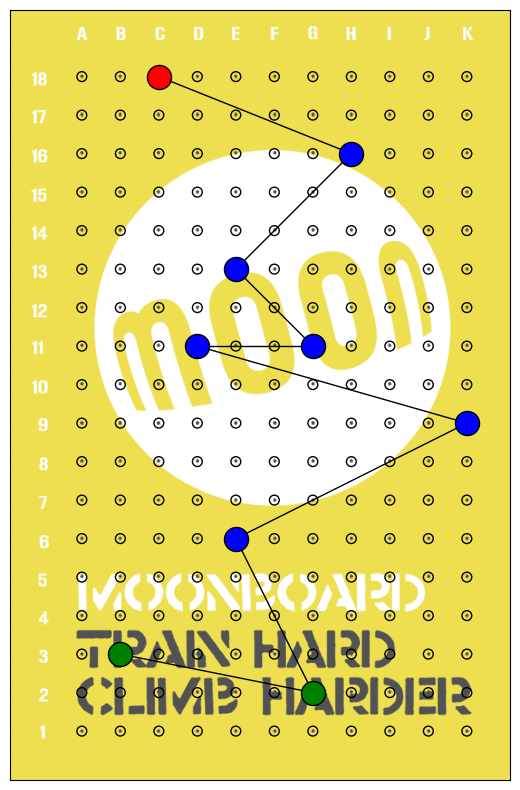

In [165]:
# Function to plot the generated climb on the Moonboard
def plot_generated_climb(climb, labels, img_path='moonboard-background.png'):
    wall_img = mpimg.imread(img_path)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(wall_img, extent=[0, wall_img.shape[1], 0, wall_img.shape[0]])

    # Get positions of holds
    pos = {hold['id']: (hold['x'], hold['y']) for hold in holds}

    # Draw all holds
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=50, node_color='none', edgecolors='black')

    # Highlight the generated climb
    for hold, label in zip(climb, labels):
        color = 'green' if label == 'starting hold' else ('blue' if label == 'intermediate hold' else 'red')
        nx.draw_networkx_nodes(G, pos, nodelist=[hold], ax=ax, node_size=300, node_color=color, edgecolors='black')

    # Optionally, draw edges of the generated climb
    climb_edges = [(climb[i], climb[i + 1]) for i in range(len(climb) - 1)]
    nx.draw_networkx_edges(G, pos, edgelist=climb_edges, ax=ax, edge_color='black')

    plt.show()

# Example usage for easy difficulty
# climb, labels = generate_climb(df_easy, prob_starting_hold_easy, prob_with_pairs_easy, conditional_second_starting_holds_info_easy, probability_matrix_easy)
climb, labels = generate_climb(df_medium, prob_starting_hold_medium, prob_with_pairs_medium, conditional_second_starting_holds_info_medium, probability_matrix_medium)
# climb, labels = generate_climb(df_hard, prob_starting_hold_hard, prob_with_pairs_hard, conditional_second_starting_holds_info_hard, probability_matrix_hard)
# climb, labels = generate_climb(df_vhard, prob_starting_hold_vhard, prob_with_pairs_vhard, conditional_second_starting_holds_info_vhard, probability_matrix_vhard)

# Plot the generated climb
plot_generated_climb(climb, labels)

# Export matrices for website use

In [166]:
# import pickle

# # Save matrices to pickle files
# with open('gen_data/prob_matrices/probability_matrix_easy.pkl', 'wb') as f:
#     pickle.dump(probability_matrix_easy, f)

# with open('gen_data/prob_matrices/probability_matrix_medium.pkl', 'wb') as f:
#     pickle.dump(probability_matrix_medium, f)

# with open('gen_data/prob_matrices/probability_matrix_hard.pkl', 'wb') as f:
#     pickle.dump(probability_matrix_hard, f)

# with open('gen_data/prob_matrices/probability_matrix_vhard.pkl', 'wb') as f:
#     pickle.dump(probability_matrix_vhard, f)

In [167]:
# import pickle

# df_prob_starting_hold_easy = pd.DataFrame.from_dict(prob_starting_hold_easy, orient='index', columns=['Probability'])
# df_prob_starting_hold_medium = pd.DataFrame.from_dict(prob_starting_hold_medium, orient='index', columns=['Probability'])
# df_prob_starting_hold_hard = pd.DataFrame.from_dict(prob_starting_hold_hard, orient='index', columns=['Probability'])
# df_prob_starting_hold_vhard = pd.DataFrame.from_dict(prob_starting_hold_vhard, orient='index', columns=['Probability'])

# df_prob_with_pairs_easy = pd.DataFrame.from_dict(prob_with_pairs_easy, orient='index', columns=['Probability'])
# df_prob_with_pairs_medium = pd.DataFrame.from_dict(prob_with_pairs_medium, orient='index', columns=['Probability'])
# df_prob_with_pairs_hard = pd.DataFrame.from_dict(prob_with_pairs_hard, orient='index', columns=['Probability'])
# df_prob_with_pairs_vhard = pd.DataFrame.from_dict(prob_with_pairs_vhard, orient='index', columns=['Probability'])

# df_conditional_second_starting_holds_info_easy = pd.DataFrame(conditional_second_starting_holds_info_easy).fillna(0)
# df_conditional_second_starting_holds_info_medium = pd.DataFrame(conditional_second_starting_holds_info_medium).fillna(0)
# df_conditional_second_starting_holds_info_hard = pd.DataFrame(conditional_second_starting_holds_info_hard).fillna(0)
# df_conditional_second_starting_holds_info_vhard = pd.DataFrame(conditional_second_starting_holds_info_vhard).fillna(0)

# df_prob_starting_hold_easy.to_pickle('gen_data/start_probs/prob_starting_hold_easy.pkl')
# df_prob_starting_hold_medium.to_pickle('gen_data/start_probs/prob_starting_hold_medium.pkl')
# df_prob_starting_hold_hard.to_pickle('gen_data/start_probs/prob_starting_hold_hard.pkl')
# df_prob_starting_hold_vhard.to_pickle('gen_data/start_probs/prob_starting_hold_vhard.pkl')

# df_prob_with_pairs_easy.to_pickle('gen_data/2hand_prob/prob_with_pairs_easy.pkl')
# df_prob_with_pairs_medium.to_pickle('gen_data/2hand_prob/prob_with_pairs_medium.pkl')
# df_prob_with_pairs_hard.to_pickle('gen_data/2hand_prob/prob_with_pairs_hard.pkl')
# df_prob_with_pairs_vhard.to_pickle('gen_data/2hand_prob/prob_with_pairs_vhard.pkl')

# df_conditional_second_starting_holds_info_easy.to_pickle('gen_data/2hand_holds/conditional_second_starting_holds_info_easy.pkl')
# df_conditional_second_starting_holds_info_medium.to_pickle('gen_data/2hand_holds/conditional_second_starting_holds_info_medium.pkl')
# df_conditional_second_starting_holds_info_hard.to_pickle('gen_data/2hand_holds/conditional_second_starting_holds_info_hard.pkl')
# df_conditional_second_starting_holds_info_vhard.to_pickle('gen_data/2hand_holds/conditional_second_starting_holds_info_vhard.pkl')


In [168]:

# # Save dictionaries/lists directly to pickle files
# with open('gen_data/start_probs/prob_starting_hold_easy.pkl', 'wb') as f:
#     pickle.dump(prob_starting_hold_easy, f)

# with open('gen_data/start_probs/prob_starting_hold_medium.pkl', 'wb') as f:
#     pickle.dump(prob_starting_hold_medium, f)

# with open('gen_data/start_probs/prob_starting_hold_hard.pkl', 'wb') as f:
#     pickle.dump(prob_starting_hold_hard, f)

# with open('gen_data/start_probs/prob_starting_hold_vhard.pkl', 'wb') as f:
#     pickle.dump(prob_starting_hold_vhard, f)

# with open('gen_data/2hand_prob/prob_with_pairs_easy.pkl', 'wb') as f:
#     pickle.dump(prob_with_pairs_easy, f)

# with open('gen_data/2hand_prob/prob_with_pairs_medium.pkl', 'wb') as f:
#     pickle.dump(prob_with_pairs_medium, f)

# with open('gen_data/2hand_prob/prob_with_pairs_hard.pkl', 'wb') as f:
#     pickle.dump(prob_with_pairs_hard, f)

# with open('gen_data/2hand_prob/prob_with_pairs_vhard.pkl', 'wb') as f:
#     pickle.dump(prob_with_pairs_vhard, f)

# with open('gen_data/2hand_holds/conditional_second_starting_holds_info_easy.pkl', 'wb') as f:
#     pickle.dump(conditional_second_starting_holds_info_easy, f)

# with open('gen_data/2hand_holds/conditional_second_starting_holds_info_medium.pkl', 'wb') as f:
#     pickle.dump(conditional_second_starting_holds_info_medium, f)

# with open('gen_data/2hand_holds/conditional_second_starting_holds_info_hard.pkl', 'wb') as f:
#     pickle.dump(conditional_second_starting_holds_info_hard, f)

# with open('gen_data/2hand_holds/conditional_second_starting_holds_info_vhard.pkl', 'wb') as f:
#     pickle.dump(conditional_second_starting_holds_info_vhard, f)


In [3]:
import pandas as pd
import statsmodels.api as sm

# Sample data
data = {
    'x1': [1, 2, 3, 4, 5],
    'x2': [5, 4, 3, 2, 1],
    'y': [2, 3, 4, 5, 6]
}
df = pd.DataFrame(data)

# Add a constant term to the predictors
exog = sm.add_constant(df[['x1', 'x2']])

# Fit a simple OLS model
model = sm.OLS(df['y'], exog)
result = model.fit()

print(result.summary())


,const,x1
0,1.0,1
1,1.0,2
2,1.0,3
3,1.0,4
4,1.0,5
